# Homework 4: Coding

**Due Monday October 10th, 11:59pm.**


**In order to avoid module version issues, please complete this assignment on Colab.**

**Submit hw4.ipynb file to Gradescope (note there is no autograder for this assignment).**

In [ ]:
"""
Import libraries that you might require
"""

import numpy as np
import math
import matplotlib.pyplot as plt
import operator
from sklearn.metrics import accuracy_score
import sklearn.model_selection as ms


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


In [ ]:
"""
Load data (MNIST digits dataset).

Note that we will skip the validation phase for
this exercise as by now you are pretty familiar with the typical Machine Learning
pipeline.
"""

from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

X = digits['data']
y = digits['target']

np.random.seed(100)
p = np.random.permutation(len(X))
X, y = X[p], y[p]

X_train, y_train = X[:1500], y[:1500]
X_test, y_test = X[1500:], y[1500:]


(1797, 64)


# Question 3.2 Convolutional Neural Networks  
In this assignment you will be training a Convolutional Neural Network on  
the Fashion MNIST dataset.  

You may find more information about the dataset [here](https://github.com/zalandoresearch/fashion-mnist).  
For this assignment we have already loaded the dataset for you.  
  
You will be using PyTorch for implementing your CNN. 

**We highly recommend following [this tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for this question** as well as referring to the [official documentation](https://pytorch.org/docs/stable/nn.html) if you are unfamiliar with Pytorch.

## Setup: Load Tensorboard

The below code is used to load [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard), which is used to visualize the training and execution of your neural network.

Run the below cells and click on the Tensorboard link produced by the third cell below while your network is training (Section 3.2.5) to plot the accuracy and loss curves.

In [ ]:
!rm -r -f ./logs

LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

Ngrok already installed


In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Tensorboard Link: http://07ed-35-234-9-125.ngrok.io


## Setup: Logger

Please look at the functions the logger class provides. You may use them to log   
training metrics like loss, accuracy and even some selected images and their  
labels to see how network parameters change during training.

In [ ]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.create_file_writer(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        with self.writer.as_default():
            tf.summary.scalar(name=tag, data=value, step=step)
        self.writer.flush()

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object as a Summary value
            with self.writer.as_default():
                tf.summary.image(name='%s/%d' % (tag, i), data=s.getvalue(), step=step)

        # Create and write Summary
        self.writer.flush()
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        with self.writer.as_default():
            tf.summary.histogram(name=tag, data=hist, step=step)
        self.writer.flush()
logger = Logger('./logs')

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms

##3.2.1 Loading the Dataset
The output of torchvision datasets are PILImage images of range [0, 1].  
We transform them to Tensors of normalized range [-1, 1].  
```Transforms.Normalize((mean,),(std,))``` basically manipulates the values of a pixel such that  
$$New\_Value = \frac{Old\_Value - Mean}{Std}$$



In [ ]:
# Define a transform to normalize the data

#TODO : Set the value of mean and the standard deviation to 
#       normalize the image from range [0,1] to the range [-1, 1]


#Begin Your Code

mean = 0.5
std = 0.5

#End Your Code

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                                ])


#TODO : Select suitable value of batch_sizes.

#Begin Your Code

train_batch_size = 30
test_batch_size = 30

#End Your Code

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=True)


# Classes
classes = {       0 :'T-shirt/top',
                  1 :'Trouser',
                  2 :'Pullover',
                  3 :'Dress',
                  4 :'Coat',
                  5 :'Sandal',
                  6 :'Shirt',
                  7 :'Sneaker',
                  8 :'Bag',
                  9 :'Ankle boot'}

##3.2.2 The Dataset
Here we show some images of the dataset.  
See how many of the categories can you recognise.



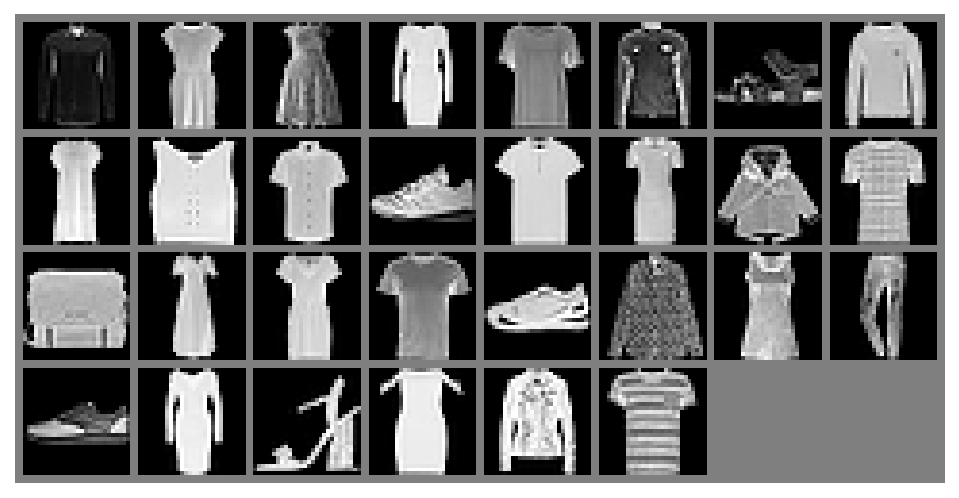

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

# Functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    
    figure(num=None, figsize=(8, 6), dpi=150, edgecolor='k')
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

##3.2.3 Create your Convolutional Neural Network
Create the CNN with layers and hyperparameter sets as mentioned in the LaTeX pdf for full credit.  
You are, however, free to change the architecture as long as you achieve accuracy better than the architecture shown in the LaTeX pdf.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #TODO : Design your network, you are allowed to explore your own architecture
        #       But you should achieve a better overall accuracy than the baseline network.
        #       Also, if you do design your own network, include an explanation 
        #       for your choice of network and how it may be better than the 
        #       baseline network in your latex.
        
        #Begin Your Code
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32,kernel_size=5, stride = 1, padding=2)
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.linear_1 = nn.Linear(64*3*3, 64)
        self.linear_2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()


        #End Your Code

    def forward(self, x):

      #TODO : Implement the forward function that applies the layers you have created to the input

      #Begin Your Code
      x = self.relu(self.conv_1(x))
      x = self.max_pool2d(x)
      x = self.relu(self.conv_2(x))
      x = self.max_pool2d(x)
      x = self.relu(self.conv_3(x))
      x = self.max_pool2d(x)
      x = x.reshape(x.size(0), -1)
      x = self.dropout(x)
      x = self.relu(self.linear_1(x))
      x = self.linear_2(x)
      return x
      #End Your Code


net = Net()

##3.2.4 Define a Loss function and optimizer
We will be using [Cross Entropy Loss](https://pytorch.org/docs/stable/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss) and [Adam optimizer](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam).  
Note: PyTorch's CrossEntropyLoss combines log softmax and negative log likelihood loss in one class. Make sure you are not computing softmax twice.



In [ ]:
import torch.optim as optim

#TODO : Use appropriate loss criterion and optimizer 

#Begin Your Code

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


#End Your Code

##3.2.5. Train the network

Here we are going to train the network while logging the per batch metrics.  
This would take some time to run (5-10 minutes).



In [ ]:
overall_step = 0

#TODO : Select appropriate number of epochs

#Begin Your Code

epochs = 10

#End Your Code
correct = 0
total = 0

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        #TODO : Make predictions, calculate accuracy and update your weights once

        #Begin Your Code

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        pred = net(inputs)
        loss = criterion(pred, labels)
        pred_result = pred.argmax(dim=1)
        correct += pred_result.eq(labels).float().sum()
        total += train_batch_size
        accuracy = correct / total
        loss.backward()
        optimizer.step()
        #End Your Code

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('Epoch: %d, Batch: %5d, loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
            #Any thing that is added to the "info" gets plotted in tensorboard
            #TODO : Add the plots in Tensorboard to the report and explain what is happening
            info = {'loss' : loss.item(), 'accuracy': accuracy.item()}
            for tag, value in info.items():
                logger.scalar_summary(tag, value, overall_step)
        
        overall_step+=1

print('Finished Training')

Epoch: 1, Batch:   200, loss: 0.970
Epoch: 1, Batch:   400, loss: 0.579
Epoch: 1, Batch:   600, loss: 0.481
Epoch: 1, Batch:   800, loss: 0.443
Epoch: 1, Batch:  1000, loss: 0.412
Epoch: 1, Batch:  1200, loss: 0.372
Epoch: 1, Batch:  1400, loss: 0.374
Epoch: 1, Batch:  1600, loss: 0.379
Epoch: 1, Batch:  1800, loss: 0.350
Epoch: 1, Batch:  2000, loss: 0.327
Epoch: 2, Batch:   200, loss: 0.311
Epoch: 2, Batch:   400, loss: 0.302
Epoch: 2, Batch:   600, loss: 0.307
Epoch: 2, Batch:   800, loss: 0.307
Epoch: 2, Batch:  1000, loss: 0.301
Epoch: 2, Batch:  1200, loss: 0.292
Epoch: 2, Batch:  1400, loss: 0.291
Epoch: 2, Batch:  1600, loss: 0.295
Epoch: 2, Batch:  1800, loss: 0.282
Epoch: 2, Batch:  2000, loss: 0.276
Epoch: 3, Batch:   200, loss: 0.253
Epoch: 3, Batch:   400, loss: 0.246
Epoch: 3, Batch:   600, loss: 0.250
Epoch: 3, Batch:   800, loss: 0.252
Epoch: 3, Batch:  1000, loss: 0.250
Epoch: 3, Batch:  1200, loss: 0.263
Epoch: 3, Batch:  1400, loss: 0.247
Epoch: 3, Batch:  1600, loss

##3.2.6 Test Accuracy
Let us look at how the network performs on the test dataset.  
Report your accuracy in your report.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

#TODO : Report this accuracy in your report.

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 90 %


##3.2.7 Per Class accuracy
Now we see the test accuracy for each class in the test dataset.  
Report these accuracies in your report. Also identify the problematic classes.  
Can you explain why these classes have significantly lower accuracies compared to other classes? Record your responses in your LaTeX file.


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 82 %
Accuracy of Trouser : 98 %
Accuracy of Pullover : 90 %
Accuracy of Dress : 93 %
Accuracy of  Coat : 78 %
Accuracy of Sandal : 96 %
Accuracy of Shirt : 73 %
Accuracy of Sneaker : 99 %
Accuracy of   Bag : 100 %
Accuracy of Ankle boot : 93 %



# Turning it in

**This notebook will not be autograded, so no need to comment out code outside of functions.**

1. Download this notebook as a `hw4.py` file with the functions implemented and the sandbox code commented out
  - go to "File -> Download .py"
  
2. Submit `hw4.py` file to Gradescope (you can do this as many times as you'd like before the deadline)